# Agas Tutorial

#### What is Agas
Agas is a small Python package allowing the user to find pairs of data series (e.g., columns in a matrix, rows in a data frame) which
optimally fit flexible criteria for their aggregated values.

For example, Agas can be used to find the two rows which satisfy the requirement of having similar median values, but vary in their standard deviations.

#### Use cases
Agas can be useful to you when you want to explore your data, or present how two units (e.g., patiants in your study) score similarly on some aggregated measure and differently on another.
You can select almost any standard or custom aggregation function you wish, and set the weight of the similarity function or divergence function flexibly.

#### Requirements
NumPy and Pandas. That's it.

## Toy-data example

In [194]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import agas

pd.set_option('display.precision', 2)
pd.set_option("display.max_columns", 5)
np.printoptions(2)

sns.set_context('notebook')


def normalize_data(s):
    """Normalize an array of values between 0 and 1.
    """
    return (s - s.min()) / (s.max() - s.min())

Our data is a matrix of size 4 X 4. Given 4 rows, there are 6 unique pairs of rows (`N(N - 1) / 2`).

In [206]:
a = np.vstack([
    [0, -1, -1, -1],
    [1, 2, 3, 4],
    [6, 9, 9, 9],
    [8, 9, 10, 11]])

We want to find pair of rows which have the most similar median values at the same time as having the most different standard deviations.

In [83]:
maximize_similarity = np.median
maximize_divergence = np.std

This matrix shows the median values on each row, and their normalized values (right column):

In [217]:
a_medians = maximize_similarity(a, axis=1)
np.vstack([a_medians, normalize_data(a_medians)]).T

array([[-1.        ,  0.        ],
       [ 2.5       ,  0.33333333],
       [ 9.        ,  0.95238095],
       [ 9.5       ,  1.        ]])

This matrix shows the standard deviations for each row, and their normalized values (right column):

In [216]:
a_sds = maximize_divergence(a, axis=1)
np.vstack([a_sds, normalize_data(a_sds)]).T

array([[0.4330127 , 0.        ],
       [1.11803399, 0.79099445],
       [1.29903811, 1.        ],
       [1.11803399, 0.79099445]])

Here it is possible to guess that the pair of rows from `a` with the highest similarity in medians and higest divergence in SDs is the pair
of two first rows, as they have relatively close median values (0 and 0.33, when normalized) and quite different standard deviations (0 and 0.79, normalized).

As you'll see below, this is also the result obtained using `Agas`.

Calling `agas.pair_from_array` below returns a tuple of two arrays:
- A 2-D array of size 6 X 2, representing the pairs of row indices.
- A 1-D array of the optimality scores of each pair (0 is the best, 1 is the worst).

In [114]:
indices, scores = agas.pair_from_array(a, maximize_similarity,
                                       maximize_divergence, return_filter='all')
print(f"The optimal score: {scores[0]} - rows {indices[0]}")
print(f"The least optimal score: {scores[-1]} - rows {indices[-1]}")

The optimal score: 0.0 - rows [0 1]
The least optimal score: 1.0 - rows [1 3]


Agas can return the matrix of optimality scores, using the `return_matrix` argument:

In [154]:
optimality_scores_matrix = agas.pair_from_array(
    a, maximize_similarity, maximize_divergence, return_matrix=True)

Viewed as a matrix, the scores match the conclusions from above where the pairing of rows 0 and 1 provides an optimal fit, while this of rows 1 and 2 provides the least favorable pair.

The diagonal of the matrix is un-colored, as `Agas` removes pairings of each row with itself:

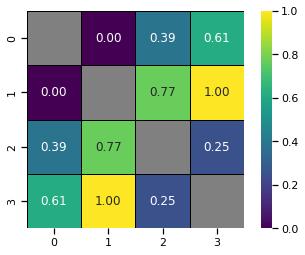

In [186]:
g = sns.heatmap(optimality_scores_matrix, square=True, annot=True,
                linewidths=1, linecolor='black', cmap='viridis', fmt=".2f")
g.set_facecolor('grey')

`Agas` can weight differently the similarity and divergence functions using the `similarity_weight` argument.
Here we favor similaritry in median value over divergence in standard deviation.

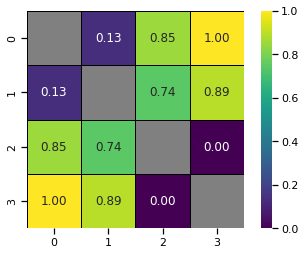

In [156]:
medians_biased_scores_mat = agas.pair_from_array(
    a, maximize_similarity, maximize_divergence, similarity_weight=0.75,
    return_matrix=True)
g = sns.heatmap(medians_biased_scores_mat, square=True, annot=True,
                linewidths=1, linecolor='black', cmap='viridis', fmt=".2f")
g.set_facecolor('grey')

# Real-world example

We load a dataset containing the GDP values for different countries and regions, 1968-2016. While a relatively a small dataset, `agas` is useful here as it is impossible to manually compare all pairs of rows.

In [187]:
url = 'https://datahub.io/core/gdp/r/gdp.csv'
df = pd.read_csv(url)
df.head()

,Country Name,Country Code,Year,Value
0,Arab World,ARB,1968,2.58e+10
1,Arab World,ARB,1969,2.84e+10
2,Arab World,ARB,1970,3.14e+10
3,Arab World,ARB,1971,3.64e+10
4,Arab World,ARB,1972,4.33e+10


Change the unit of Value (GDP) from $ to trillions, for easier readability

In [218]:
df['Value'] /= 1e12 

Remove the top and bottom 2.5 percentiles

In [189]:
total_per_country = df.groupby('Country Name')['Value'].sum()
non_outliers = total_per_country[total_per_country.between(
    *total_per_country.quantile([0.025, 0.975]))].index
df = df.loc[df['Country Name'].isin(non_outliers)]

Considerable number of countries and regions have no data until the 1990s:

[Text(0.5, 0, 'Year'), Text(0, 0.5, 'Proportion of non-missing data')]

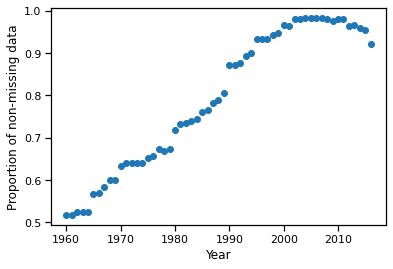

In [190]:
ax = plt.scatter(df['Year'].sort_values().unique(),
                 df.groupby('Year')['Country Name'].nunique() / df[
                     'Country Name'].nunique())
plt.gca().set(xlabel='Year', ylabel='Proportion of non-missing data')

Pivoting the data frame, as `Agas` 0.0.1 only handles wide-format data.

In [199]:
wide_df = df.loc[df['Year'].gt(1990)].pivot(columns='Year', values='Value',
                                            index='Country Name')
wide_df.sample(5, random_state=42)

Year,1991,1992,...,2015,2016
Country Name,,,,,
Bolivia,5.34e-03,5.64e-03,...,3.30e-02,3.38e-02
Antigua and Barbuda,4.82e-04,4.99e-04,...,1.36e-03,1.46e-03
Monaco,2.48e-03,2.74e-03,...,NaN,NaN
Sub-Saharan Africa (excluding high income),3.19e-01,3.13e-01,...,1.60e+00,1.51e+00
Virgin Islands (U.S.),1.67e-03,1.77e-03,...,3.77e-03,NaN


Here we use `agas.pair_from_wide_df`, which behaves similary to `agas.pair_from_array` used above.

In [200]:
indices, scores = agas.pair_from_wide_df(
    wide_df, np.nanstd, np.median, similarity_weight=0.7, return_filter='all')

C:\Users\Eitan Hemed\OneDrive - University of Haifa\PhD\python_projects\agas\agas\_from_numpy.py:266: RuntimeWarning: The result of aggregating the input scores using the function median resulted in 45 NaN scores.
  warnings.warn(f"The result of aggregating the input scores using the "


Select the optimal pair - two entries which are most similar in their variances (`np.nanstd`) and most divergent in their median GDP values (`np.nanmedian`).

In [201]:
wide_df.iloc[indices[0].flatten()].agg([np.nanmedian, np.nanstd], axis=1)

,nanmedian,nanstd
Country Name,,
China,1.81,3.72
United States,11.89,3.86


China and United States show similar variability in their GDP, but different median values.
It is interesting to explore other relationships between pairs of data points, as we do using the plot below.

In [202]:
# Normalized aggregated data
sds = normalize_data(wide_df.std(ddof=0, axis=1))
medians = normalize_data(wide_df.mean(axis=1))

# Indices of interesting data points, the most otpimal, least optimal and
country_indices = np.arange(0, wide_df.index.nunique())
scores_of_interest = [0, scores[scores.size // 2], 1]
scores_of_interest_indices = indices[np.in1d(scores, scores_of_interest)]
country_indices = country_indices[
    ~np.in1d(country_indices, scores_of_interest_indices)]

# Plot asthetics
plot_colors = ['deepskyblue', 'purple', 'green', 'orange']
scores_of_interest_labels = ['Optimal', 'Middling', 'Least Optimal']
scores_of_interest_line_styles = ["solid", "dotted", "dashed"]

colors = np.repeat(plot_colors[0], wide_df.shape[0])
alphas = np.ones_like(colors).astype(float) * 0.1

The plot below shows the data, first raw and then noramlized and aggregated. The most optimal pair was United States and china, which have similar variance and divergent median GDP as shown above.

the least optimal pair was Israel and Swaziland, which show divergent standard deviations and similar medians.

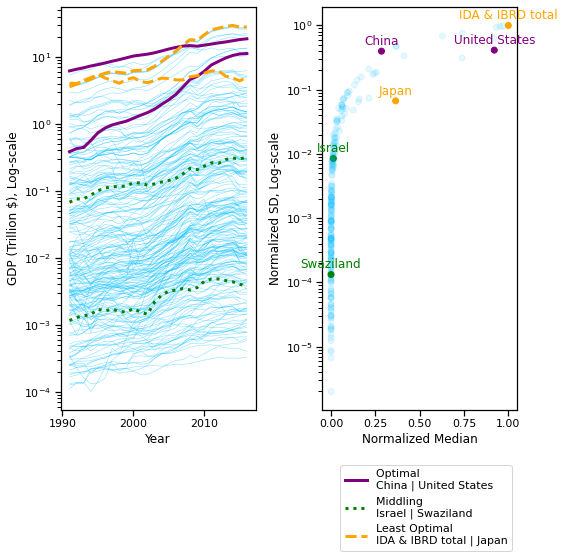

In [204]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8),
                        gridspec_kw={'height_ratios': [8, 1]})
raw_data_ax, norm_aggrgated_data_ax, _ax_to_remoev, legend_ax = axs.flat

# Plot the data excluding the data matching the points of interest
raw_data_ax.plot(wide_df.iloc[country_indices].T, c='deepskyblue', alpha=0.5,
                 lw=0.5)
raw_data_ax.set(xlabel='Year', ylabel='GDP (Trillion $), Log-scale')


for current_row_indices, _color, lab, ls in zip(scores_of_interest_indices,
                                                plot_colors[1:],
                                                scores_of_interest_labels,
                                                scores_of_interest_line_styles
                                                ):
    country_labels = wide_df.index[current_row_indices]
    colors[current_row_indices] = _color
    alphas[current_row_indices] = 1

    raw_data_ax.plot(wide_df.iloc[current_row_indices].T,
                     c=_color, label=f'{lab} \n' + ' | '.join(country_labels),
                     lw=3, ls=ls)

    for idx, l in zip(current_row_indices, country_labels):
        norm_aggrgated_data_ax.annotate(xy=[medians[idx], sds[idx] * 1.25], text=l,
                                        color=_color, ha='center')

# Scatter the normalized and aggregated data
norm_aggrgated_data_ax.scatter(medians, sds, c=colors, alpha=alphas)
norm_aggrgated_data_ax.set(xlabel='Normalized Median', ylabel='Normalized SD, Log-scale')

# # Remove duplicate entries in the legend and place in the lower row of axis
handles, country_labels = raw_data_ax.get_legend_handles_labels()
by_label = dict(zip(country_labels, handles))
legend_ax.legend(by_label.values(), by_label.keys())
legend_ax.axis('off')
_ax_to_remoev.remove()

norm_aggrgated_data_ax.set_yscale('log')
raw_data_ax.set_yscale('log')


fig.tight_layout()

## Algorithm 

Finding the optimal pair is composed of several steps. The logic is demonstrated here usign a simple example. 

0. Definitions

Let `A` be a matrix of size N X T. Here `A` is a 4 x 4 matrix.

$$ A = \begin{pmatrix} \\ 1 & 1 & 1 & 0 \\ 1 & 2 & 3 & 4 \\ 9 & 9 & 9 & 9\\ 8 & 9 & 10 & 11
    \end{pmatrix}$$


Let `MX` and `MN` be two functions which given a vector produce a scaler. Here `MX` is the population standard deviation

\begin{equation}
\sigma = \sqrt\frac{\sum{(X-\mu)^2}}{N}
\end{equation}

and `MN` is the median

\begin{cases}
  x_\frac{n+1}{2}                                    & n\text{ odd}\\
  \frac {1}{2}\left(x_{\frac{n}{2}} + x_{\frac{n}{2} + 1}\right) & n \text{ even}
\end{cases}


Each of `MX` and `MN` will be applied on the rows of `A`, resulting in the following vectors:

$$ MX(A) = \begin{pmatrix} \\ 0.43 \\ 1.19 \\ 0 \\ 1.19
    \end{pmatrix}$$

$$ MN(A) = \begin{pmatrix} \\ 1 \\ 2.5 \\ 9 \\ 9.5
    \end{pmatrix}$$

Each of MX(A) and MN(A) will be subtracted from itself:

Each of these vectors will be normalized between 0 and 1:

\begin{equation}
x' = \frac{x - \min{x}}{\max{x} - \min{x}}
\end{equation}

Resulting in these two vectors:

$$ Normalized  MX(A) = \begin{pmatrix} \\ 0.39 \\ 1 \\ 0 \\ 1
    \end{pmatrix}$$

$$ Normalized MN(A) = \begin{pmatrix} \\ 0 \\ 0.17 \\ 0.94 \\ 1
    \end{pmatrix}$$

Each of the vectors is multiplied by its respective weight `WMX` and `WMN`, defaulting to 0.5, and they are subtracted from each other:

    \begin{equation}
    $$ wmx * \begin{pmatrix} \\ 0.39 \\ 1 \\ 0 \\ 1 \end{pmatrix} - wmn * \begin{pmatrix} \\ 0 \\ 0.17 \\ 0.94 \\ 1
        \end{pmatrix}$$ = $$  \begin{pmatrix} \\ 0.19 \\ 0.41 \\ -0.47 \\ 0 \end{pmatrix} $$
    \end{equation}

And Normalized once again
    \begin{equation}
    \begin{pmatrix} \\ 0.75 \\ 1 \\ 0 \\ 0.53 \end{pmatrix}
    \end{equation}

